# LIGA DE INVERSORES: DESCARGA Y ANÁLISIS DE FONDOS

In [1]:
from google.auth.transport.requests import Request
from google.oauth2 import service_account
from google.cloud import bigquery
from google.auth.exceptions import DefaultCredentialsError
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# DESCARGA DE LOS DATOS

Se cargan las credenciales para poder autenticarse.

In [2]:
try:
    # Crear las credenciales a partir del archivo de cuenta de servicio
    credentials = service_account.Credentials.from_service_account_file(
        'credenciales_liga_inversores.json',  # Ruta al archivo JSON que contiene las credenciales
        scopes=["https://www.googleapis.com/auth/bigquery"]  # Ámbito de acceso para BigQuery
    )

    # Refrescar el token de acceso en caso de que haya expirado
    credentials.refresh(Request())  # Refresca el token utilizando una solicitud de autorización
    print("Credenciales cargadas y token refrescado con éxito.")  # Imprime un mensaje de éxito

# Si ocurre un error relacionado con las credenciales, se captura y muestra el error
except DefaultCredentialsError as e:
    print(f"Error de credenciales: {e}")  # Muestra el mensaje de error relacionado con las credenciales

# Si ocurre cualquier otro tipo de error, se captura y muestra el error
except Exception as e:
    print(f"Se produjo un error: {e}")  # Muestra un mensaje general para cualquier otro error


Credenciales cargadas y token refrescado con éxito.


La lista de códigos ISIN (International Securities Identification Number) se genera como una cadena de texto en la que cada código ISIN está entre comillas y separado por comas. Para crearla, debes incluir los códigos ISIN válidos de los activos financieros que estás analizando.

In [3]:
#ListaISIN = "'LU0625737753','FR0013289022','IE00B3XXRP09','DE000A0H08M3','NL0000289783','CH0012221716','HK0000069689'"

ListaISIN = "'LU0625737753','IE00B3XXRP09','DE000A0H08M3','NL0000289783','CH0012221716','HK0000069689'"

Este código realiza una consulta en Google BigQuery para obtener datos de valor liquidativo (NAV) de activos financieros identificados por códigos ISIN

In [4]:
# Proyecto en el que se ejecuta.
project = 'ironia-data'

#Creacion  del cliente

client = bigquery.Client(project=project, credentials=credentials)
sql_str = "SELECT * FROM( SELECT date,isin,nav FROM ironia-data.ironia.navs WHERE date BETWEEN '2020-01-01' AND CURRENT_DATE()) PIVOT (MAX(nav) FOR isin IN (" + ListaISIN + ")) ORDER BY Date ASC"


Da formato a los valores y muestra, para cada fondo, cuántos valores válidos (non-null) tiene

In [5]:
precios_fondos = client.query(sql_str).to_dataframe()

precios_fondos = precios_fondos.set_index("date")

precios_fondos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1892 entries, 2020-01-01 to 2025-03-06
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LU0625737753  1208 non-null   float64
 1   IE00B3XXRP09  1274 non-null   float64
 2   DE000A0H08M3  1317 non-null   float64
 3   NL0000289783  1283 non-null   float64
 4   CH0012221716  0 non-null      float64
 5   HK0000069689  0 non-null      float64
dtypes: float64(6)
memory usage: 103.5 KB


Elimina los fondos que no tienen ningún valor válido y luego los días en los que no hay valores válidos. Luego guarda los valores en un fichero excel llamado precios_fondos.xlsx

In [6]:
precios_fondos = precios_fondos.dropna(axis=1, how='all')

precios_fondos = precios_fondos.dropna()

precios_fondos.to_excel('precios_fondos.xlsx',index=False)

Mostrar los datos ya limpios

In [7]:
precios_fondos

,LU0625737753,IE00B3XXRP09,DE000A0H08M3,NL0000289783
date,,,,
2020-03-27,127.91,41.6400,20.8900,38.21
2020-03-30,127.32,41.6400,20.7500,39.36
2020-03-31,130.36,41.6400,22.0300,39.73
2020-04-01,128.32,41.6400,22.0300,38.53
2020-04-02,130.61,41.6400,22.9300,39.39
...,...,...,...,...
2025-02-27,147.46,113.0400,36.4079,83.55
2025-02-28,142.21,111.2500,36.4079,84.85
2025-03-03,141.48,111.2500,36.2098,83.05


_____________________________________________________________________________________________________________________________

# ANÁLISIS DE LOS DATOS

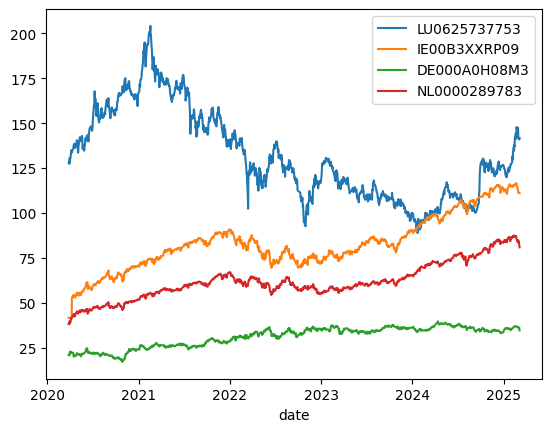

In [8]:
precios_fondos.plot();

Vamos a crear un índice para comparar visualmente los activos de la cartera. Dividimos los precios actuales con los del instante de tiempo inicial `precios_fondos.iloc[0]`.

<Axes: xlabel='date'>

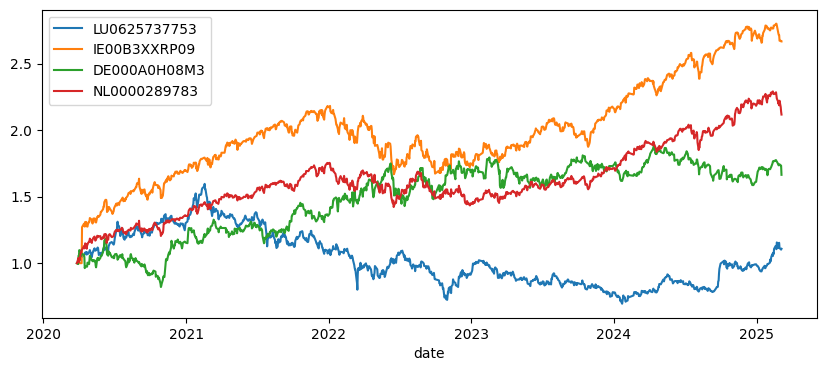

In [9]:
(precios_fondos/precios_fondos.iloc[0]).plot(figsize=(10, 4))

En finanzas trabajamos con retornos porque nos centramos en **cómo los activos cambian** en comparación con su valor anterior, en lugar de mirar directamente el precio absoluto. Al hacerlo, podemos comparar diferentes activos y entender mejor cómo varían, lo que facilita la toma de decisiones y el análisis sin verse afectados por las diferencias en la escala de los precios.

<Axes: xlabel='date'>

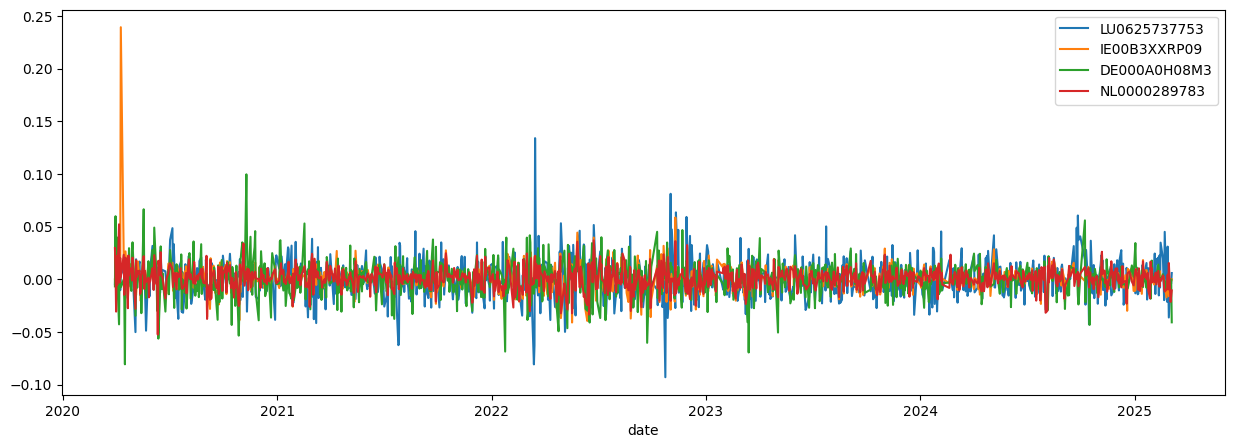

In [10]:
returns_fondos = np.log(precios_fondos).diff().dropna()

returns_fondos.plot(figsize=(15,5))

In [11]:
retornos_fondos_acum = returns_fondos.cumsum()

<Axes: xlabel='date'>

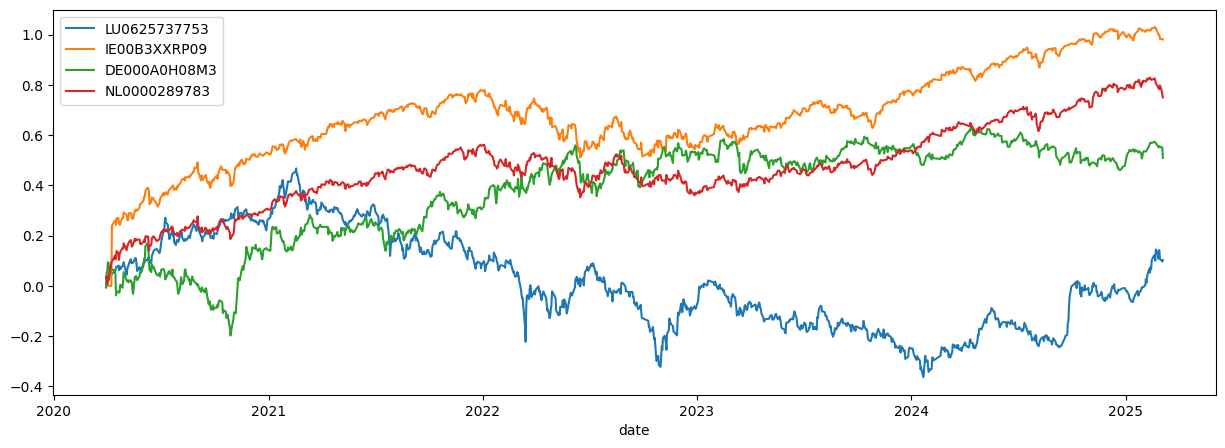

In [12]:
retornos_fondos_acum.plot(figsize=(15,5))

Veamos ahora la distribución de los retornos. ¿A qué distribución se parece?

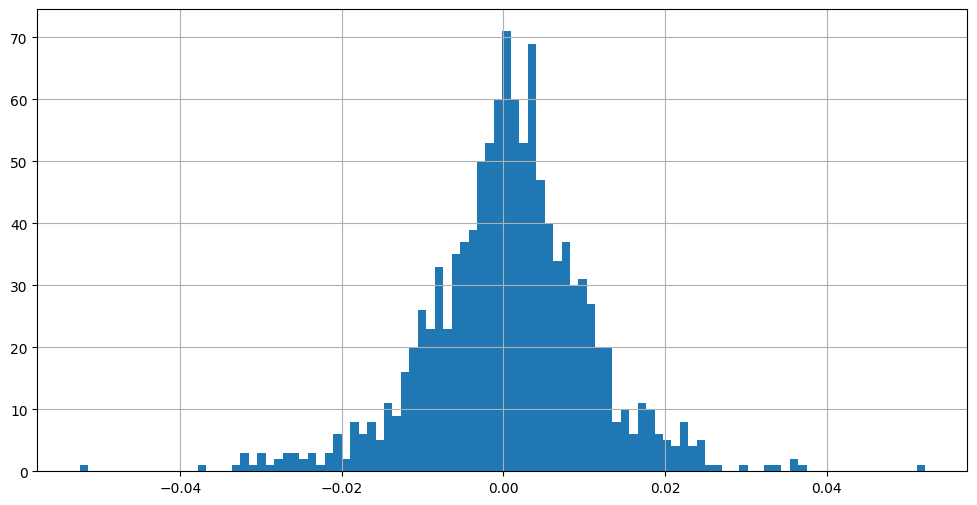

In [13]:
fondo = 'NL0000289783'

returns_fondos.loc[:, fondo].hist(bins=100, figsize=(12,6));

RECORDAD: La distribución normal se caracteriza por dos parámetros: la media (
𝜇), que determina su centro, y la desviación estándar (𝜎), que define su dispersión.

In [14]:
retornos_medios = returns_fondos.mean()
retornos_año = 252 * retornos_medios

In [15]:
volatilidades = returns_fondos.std()
volatilidades_año = np.sqrt(252) * volatilidades

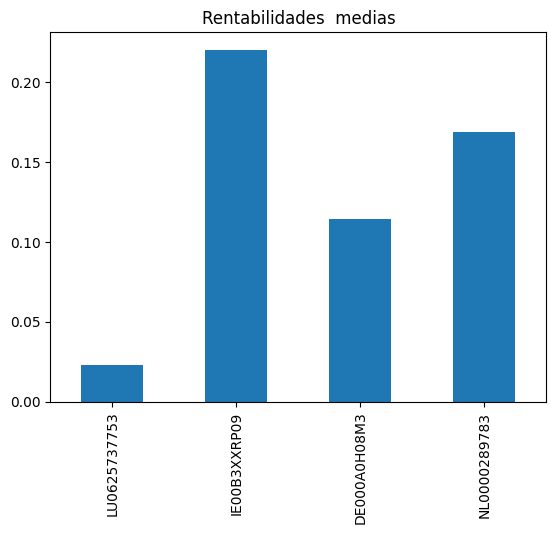

In [16]:
retornos_año.plot(kind='bar', title="Rentabilidades  medias");

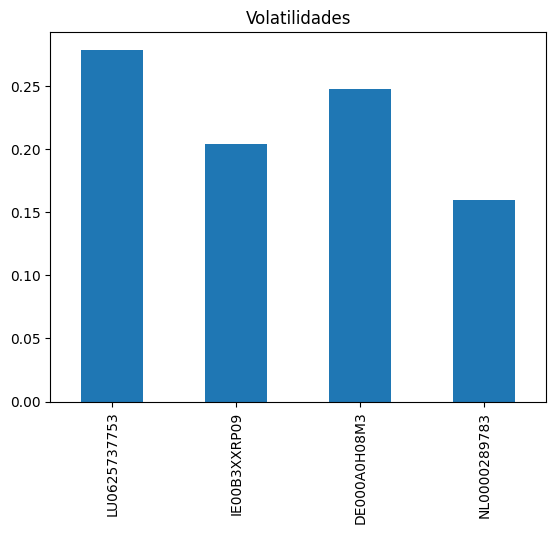

In [17]:
volatilidades_año.plot(kind='bar', title="Volatilidades");

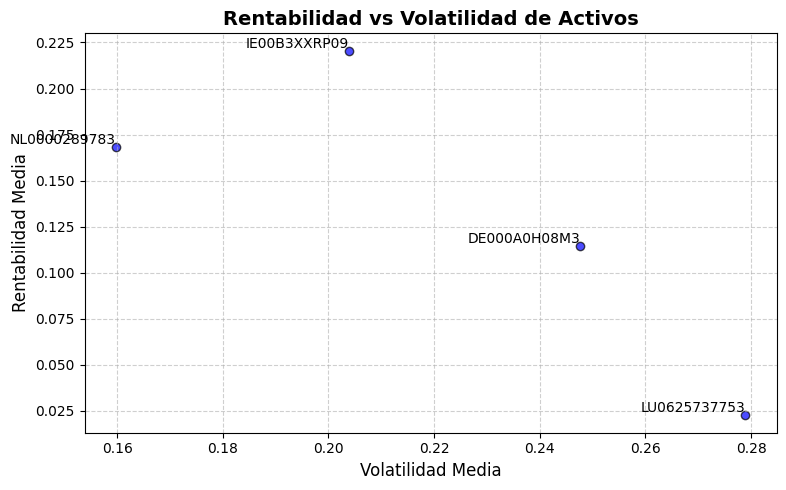

In [18]:
# Extraer las etiquetas de los nombres de las columnas
etiquetas = volatilidades.index

# Crear la gráfica con etiquetas
plt.figure(figsize=(8, 5))
plt.scatter(volatilidades_año, retornos_año,
            color='blue', edgecolors='black', alpha=0.7)

# Agregar etiquetas a los puntos
for etiqueta, x, y in zip(etiquetas, volatilidades_año, retornos_año):
    plt.text(x, y, etiqueta, fontsize=10, ha='right', va='bottom')

# Etiquetas y título
plt.xlabel('Volatilidad Media', fontsize=12)
plt.ylabel('Rentabilidad Media', fontsize=12)
plt.title('Rentabilidad vs Volatilidad de Activos', fontsize=14, fontweight='bold')

# Agregar grid y mejorar visualización
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

**OJO**

La rentabilidad de la cartera depende de las rentabilidades de cada activo ponderadas por sus respectivos pesos, mientras que la **varianza de la cartera** depende no solo de las varianzas individuales de los activos, sino también de las **covarianzas entre ellos**, reflejando cómo se relacionan sus movimientos.



Si llamamos:

* $n$ al número de activos en la cartera

* $w_i$ a la proporción de la inversión en el activo $i$ $\Rightarrow \sum_{i=1}^{n}w_i=1$

* $\bar R_i$ a la rentabilidad media del activo $i$

* $\sigma_{ij}$ a la covarianza entre los activos $i$ y $j$

Entonces:

* **Rentabilidad media** de la cartera $E(\tilde R_p) = \bar R_p = \sum_{i=1}^{N}w_i E(\tilde R_i)$

* **Varianza** de la cartera: $\sigma²(\tilde R_p) = \sigma_p^2= \underset{Varianzas\ activos} {\underbrace{\sum_{i=1}^{N} w_i²} \sigma _i²} + \underset{Relación\ entre\ activos} {\underbrace{\sum_{i=1}^{N}\sum_{j=1}^{N}w_iw_j\sigma_{ij}}}$


In [19]:
mat_cov = returns_fondos.cov()

<Axes: >

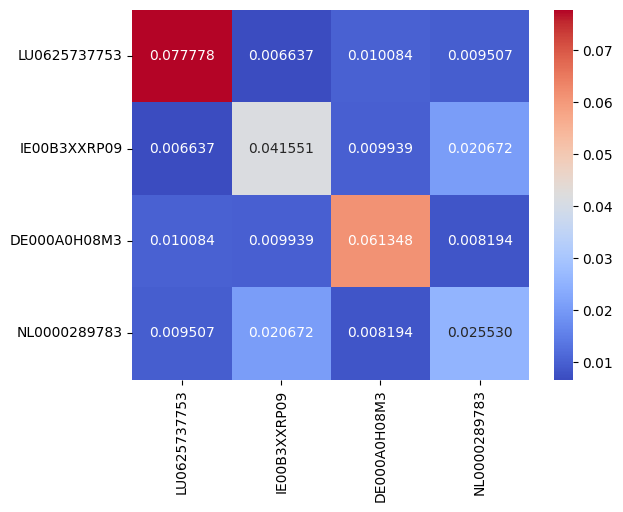

In [20]:
sns.heatmap(252*mat_cov, annot=True, fmt=".6f", cmap="coolwarm")

In [21]:
mat_corr = returns_fondos.corr()
mat_corr

,LU0625737753,IE00B3XXRP09,DE000A0H08M3,NL0000289783
LU0625737753,1.000000,0.116743,0.145989,0.213354
IE00B3XXRP09,0.116743,1.000000,0.196861,0.634682
DE000A0H08M3,0.145989,0.196861,1.000000,0.207041
NL0000289783,0.213354,0.634682,0.207041,1.000000


<Axes: >

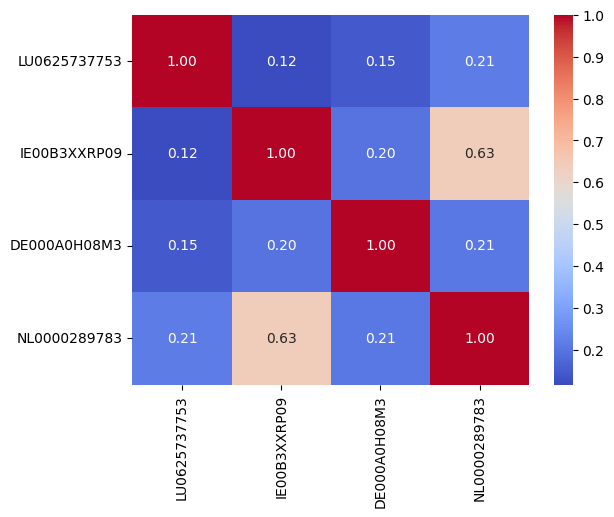

In [22]:
# Crear el heatmap con valores en las celdas
sns.heatmap(mat_corr, annot=True, fmt=".2f", cmap="coolwarm")

**Rentabilidad** de la cartera $E(\tilde R_p)=\sum_{i=1}^{N}w_i E(\tilde R_i)$

$E(\tilde R_p)=\begin{pmatrix}w_1 & w_2 & ... & w_N\end{pmatrix}  \begin{pmatrix}\mu_1 \\\mu_2  \\...  \\ \mu_N\end{pmatrix} = \mathbf{w}^T\mathbf{\mu}$

In [23]:
num_activos = returns_fondos.shape[1]

In [24]:

pesos = np.ones(num_activos)/num_activos
pesos

array([0.25, 0.25, 0.25, 0.25])

In [25]:
ret_cartera_año = pesos.T @ retornos_año
ret_cartera_año

0.131424636965104

$\sigma²(\tilde R_p)=\begin{pmatrix}w_1 & w_2 & ... & w_N\end{pmatrix} \begin{pmatrix}\sigma_1^2 & \sigma_{12}^2 & ... & \sigma_{1N}^2\\
 \sigma_{21}^2& \sigma_2^2 &...  & \sigma_{2N}^2\\ ... & ... & ... & ...\\  \sigma_{N1}^2& \sigma_{N2}^2 & ... & \sigma_N^2\end{pmatrix} \begin{pmatrix}w_1 \\w_2  \\...  \\ w_N\end{pmatrix} = \mathbf{w}^T\mathbf{C}\mathbf{w}$

In [26]:
var_cartera = pesos.T @ mat_cov @ pesos
var_cartera_año = 252 * var_cartera
vol_cartera_año = np.sqrt(var_cartera_año)
vol_cartera_año


0.14497287274461146

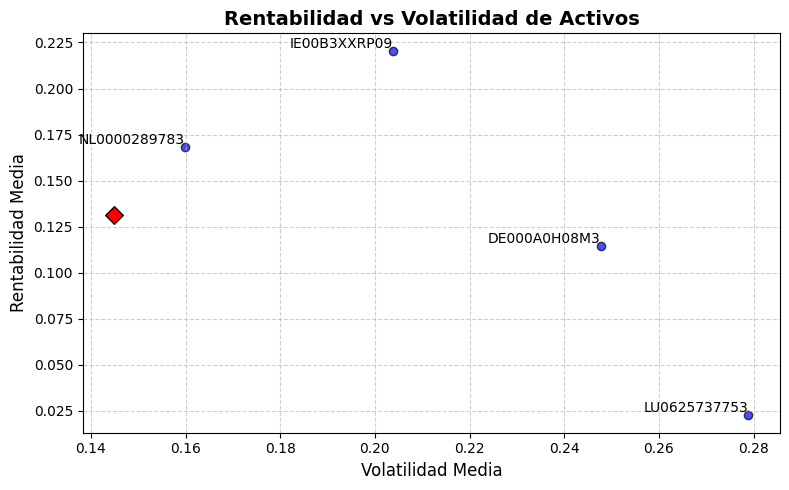

In [27]:
# Extraer las etiquetas de los nombres de las columnas
etiquetas = volatilidades.index

# Crear la gráfica con etiquetas
plt.figure(figsize=(8, 5))
plt.scatter(volatilidades_año, retornos_año,
            color='blue', edgecolors='black', alpha=0.7)

# Agregar etiquetas a los puntos
for etiqueta, x, y in zip(etiquetas, volatilidades_año, retornos_año):
    plt.text(x, y, etiqueta, fontsize=10, ha='right', va='bottom')

# Agregar el punto para la cartera
plt.scatter(vol_cartera_año, ret_cartera_año,
            color='red', edgecolors='black', marker='D', s=80, label='Cartera')

# Etiquetas y título
plt.xlabel('Volatilidad Media', fontsize=12)
plt.ylabel('Rentabilidad Media', fontsize=12)
plt.title('Rentabilidad vs Volatilidad de Activos', fontsize=14, fontweight='bold')

# Agregar grid y mejorar visualización
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

______________________________________________

### ¿Cómo calcular los retornos de una cartera?

Si tenemos un vector $w$ que representa los pesos de los activos en la cartera y un DataFrame llamado `retornos` que contiene los retornos diarios de los activos, podemos calcular los retornos diarios de la cartera mediante el producto matricial:

$$
r_{\text{cartera}} = retornos @ w
$$

Esto multiplica cada fila del DataFrame `retornos` por el vector de pesos $w$, obteniendo así los retornos diarios de la cartera.


In [28]:
ret_cartera_t = returns_fondos @ pesos
ret_cartera_t

,0
date,
2020-03-30,0.004576
2020-03-31,0.023203
2020-04-01,-0.011611
2020-04-02,0.019951
2020-04-03,-0.001522
...,...
2025-02-27,-0.000647
2025-02-28,-0.009194
2025-03-03,-0.008011


<Axes: xlabel='date'>

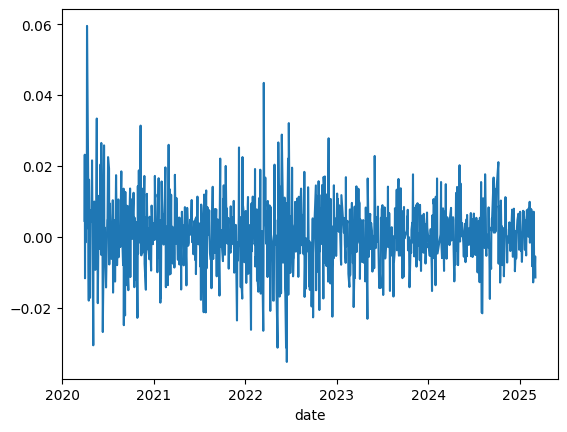

In [29]:
ret_cartera_t.plot()

In [30]:
ret_cartera_t_año = 252 * ret_cartera_t.mean()
vol_cartera_t_año = np.sqrt(252) * ret_cartera_t.std()

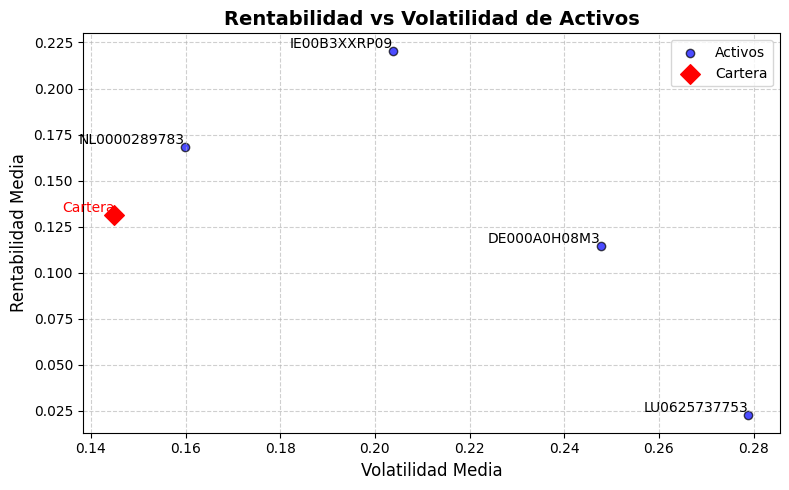

In [31]:
# Crear la gráfica con etiquetas
plt.figure(figsize=(8, 5))
plt.scatter(volatilidades_año, retornos_año,
            color='blue', edgecolors='black', alpha=0.7, label='Activos')

# Agregar etiquetas a los puntos
for etiqueta, x, y in zip(etiquetas, volatilidades_año, retornos_año):
    plt.text(x, y, etiqueta, fontsize=10, ha='right', va='bottom')

# Agregar el punto de la cartera con otro símbolo
plt.scatter(vol_cartera_t_año, ret_cartera_t_año, color='red', marker='D', s=100, label='Cartera')
plt.text(vol_cartera_t_año, ret_cartera_t_año, 'Cartera', fontsize=10, ha='right', va='bottom', color='red')

# Etiquetas y título
plt.xlabel('Volatilidad Media', fontsize=12)
plt.ylabel('Rentabilidad Media', fontsize=12)
plt.title('Rentabilidad vs Volatilidad de Activos', fontsize=14, fontweight='bold')

# Agregar grid y mejorar visualización
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [32]:
ret_cartera_t_acum = ret_cartera_t.cumsum()


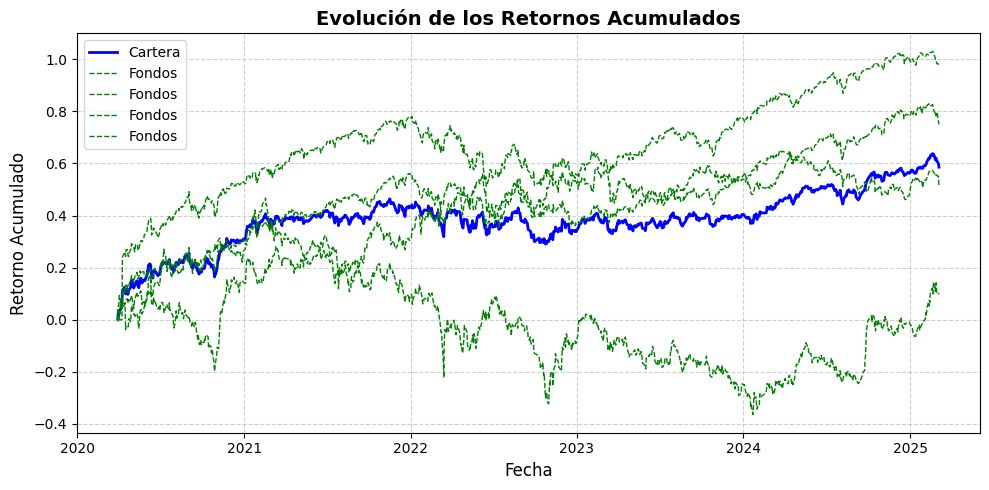

In [33]:
# Crear la figura
plt.figure(figsize=(10, 5))

# Graficar ambos retornos acumulados
plt.plot(ret_cartera_t_acum, label='Cartera', linewidth=2, color='blue')
plt.plot(retornos_fondos_acum, label='Fondos', linewidth=1, color='green', linestyle='dashed')

# Personalización
plt.title('Evolución de los Retornos Acumulados', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Retorno Acumulado', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Mostrar la gráfica
plt.show()


In [34]:
num_carteras = 50000
pesos_alea = pesos = np.random.random((num_carteras, num_activos))
pesos = pesos / np.sum(pesos, axis=1, keepdims=True)
pesos.shape

(50000, 4)

In [35]:
ret_cartera_t.shape

(1123,)

In [36]:
ret_carteras_sim = returns_fondos @ pesos.T
ret_carteras_sim.shape

(1123, 50000)

In [37]:
ret_carteras_sim_mean = ret_carteras_sim.mean(axis=0)
ret_carteras_sim_mean.shape

(50000,)

In [38]:
vol_carteras_sim = ret_carteras_sim.std(axis=0)
vol_carteras_sim.shape

(50000,)

In [39]:
ret_carteras_sim_mean_año = 252 * ret_carteras_sim_mean
vol_carteras_sim_año = np.sqrt(252) * vol_carteras_sim

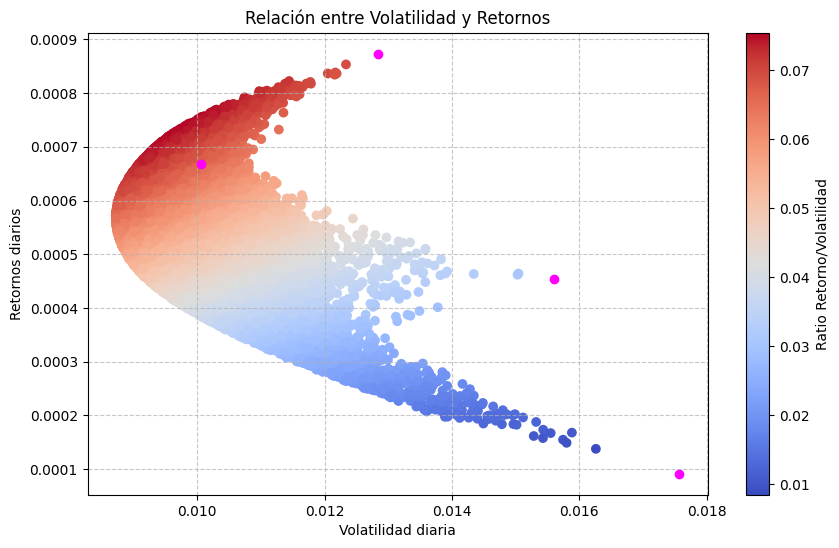

In [40]:
# Ajustar el tamaño de la figura (ancho x alto en pulgadas)
plt.figure(figsize=(10, 6))

plt.scatter(vol_carteras_sim, ret_carteras_sim_mean, c=ret_carteras_sim_mean / vol_carteras_sim, marker='o', cmap='coolwarm')
for a in returns_fondos.columns:
    plt.plot(volatilidades[a], retornos_medios[a], 'o', color="magenta")

# Añadir etiquetas a los ejes
plt.xlabel('Volatilidad diaria')
plt.ylabel('Retornos diarios')

# Título opcional para el gráfico
plt.title('Relación entre Volatilidad y Retornos')

plt.colorbar(label='Ratio Retorno/Volatilidad')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


# VAMOS A OPTIMIZAR CARTERAS CON ESTOS ACTIVOS

Nuestro objetivo es **mimimizar/maximizar $f_0(x|w)$** sujeto a $f_i(x|w) \leq b_i$,   $\qquad i= 1,...,m$

donde:

- $x = (x_1, x_2,..., x_n)$ son las variables

- $w = (w_1, w_2,..., w_n)$ son los parámetros

- $f_0: \mathbb{R}^n \rightarrow \mathbb{R}$  es la función objetivo

- $f_i: \mathbb{R}^n \rightarrow \mathbb{R}$ son las restricciones

**Solución**: $w^*$ son los parámetros, de entre todos los vectores que cumplen las restricciones, que hace que $f_0(x | w^*)$ tenga el valor mínimo/máximo.

**EJEMPLO: OPTIMIZACIÓN DE UNA CARTERA**

- *variables:*     retornos esperados de cada activo
- *parámetros:*    cantidades o pesos que invierto en cada activo
- *restricciones:* presupuesto total, max/min cantidad invertida en un activo, retorno mínimo de la cartera
- *objetivo:*      riesgo o volatilidad

Las ventajas de los problemas de optimización convexa incluyen:

- **Solución Óptima Global**: Cualquier mínimo local es también un mínimo global, lo que asegura que la solución encontrada es la mejor posible.

- **Amplia Aplicabilidad**: Los problemas de optimización convexa son relevantes en muchos campos, como la economía, la ingeniería, el machine learning y la investigación operativa.

- **Simplicidad de Implementación**: Los algoritmos para resolver problemas convexos son sencillos de implementar.

- **Eficiencia Computacional**: Los algoritmos para resolver problemas convexos son generalmente eficientes y bien entendidos, lo que permite soluciones rápidas y confiables.

Los problemas de optimización de carteras de activos financieros son **PROBLEMAS DE OPTIMIZACIÓN CONVEXA**:

1. **Función Objetivo Convexa**:
   - En la optimización de carteras, como en el modelo de Markowitz, la función objetivo suele ser minimizar el riesgo (varianza o desviación estándar) o maximizar el rendimiento esperado.
   - La varianza (riesgo) es una función cuadrática de los pesos de los activos, que es convexa por definición.
   
<br>

2. **Restricciones Convexas**:
    - Las restricciones comunes, como la suma de los pesos igual a 1 y las restricciones de no-negatividad, son lineales (afines). Estas restricciones son convexas, lo que significa que el conjunto de soluciones posibles (el espacio factible) es un conjunto convexo.

Para la **resolución de problemas de optimización convexa en python** existen básicamente 3 métodos:

- Implementación de los distintos algoritmos de optimización (solvers), como, por ejemplo, Gurovi, Scipy PuLP, GLPK, CPLEX, etc.

- Diseño de tu propio algoritmo (modelos de Machine Learning).

- Usar una librería de alto nivel (CVXPY), que integra los solvers estandar usando un lenguaje de alto nivel.

**CVXPY** es un lenguaje específico para la optimización convexa integrado en Python. Sus características principales incluyen:
  
- **Expresión Natural de Problemas**:
  - Permite a los usuarios formular problemas de optimización convexa utilizando una sintaxis de alto nivel que sigue la lógica matemática.

- **Compatibilidad con Solucionadores Conocidos**:
  - Facilita el uso de los solvers de optimización más conocidos
  
- **Verifica que el problema es convexo**:
  - La librería tiene herramientas para comprobar si el problema de optimización es convexo.

In [41]:
import cvxpy as cp

In [42]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'GLPK', 'GLPK_MI', 'HIGHS', 'OSQP', 'SCIPY', 'SCS']


In [43]:
returns_fondos.head()

,LU0625737753,IE00B3XXRP09,DE000A0H08M3,NL0000289783
date,,,,
2020-03-30,-0.004623,0.0,-0.006724,0.029653
2020-03-31,0.023596,0.0,0.059859,0.009356
2020-04-01,-0.015773,0.0,0.000000,-0.030669
2020-04-02,0.017689,0.0,0.040041,0.022075
2020-04-03,-0.000996,0.0,0.000000,-0.005090


In [44]:
mat_cov = returns_fondos.cov().to_numpy()
mat_cov.shape

(4, 4)

In [45]:
num_activos = returns_fondos.shape[1]

In [46]:
# definimos los parámetros
pesos = cp.Variable(num_activos)

In [47]:
#Restricciones
constraints = [pesos >= 0,
               cp.sum(pesos) == 1,
               ]

In [48]:
# Función objetivo
riesgo = cp.quad_form(pesos, mat_cov)
objetivo = cp.Minimize(riesgo)

In [49]:
#Problema y resuelvo
prob = cp.Problem(objetivo, constraints)
resultado = prob.solve()

In [50]:
ret = retornos_medios.T @ pesos.value

In [51]:
print(f'Los pesos que hacen que la cartera tenga el mínimo riesgo son: \n{pesos.value}')

Los pesos que hacen que la cartera tenga el mínimo riesgo son: 
[0.14519371 0.12697659 0.19714606 0.53068365]


In [52]:
print(f' La rentabilidad es {252*ret} y la volatilidad es {np.sqrt(252*riesgo.value)}')

 La rentabilidad es 0.14313205237812568 y la volatilidad es 0.13845268408077555


In [56]:
#riesgo máximo
riesgo_obj = 0.011

In [57]:
pesos_riesgo = cp.Variable(num_activos)
retornos_esperados = retornos_medios.to_numpy()

# Función objetivo
rentabilidad = cp.Maximize(retornos_esperados.T @ pesos_riesgo)

#Restricciones
riesgo = cp.quad_form(pesos_riesgo, mat_cov)

constraints = [pesos_riesgo >= 0,
                cp.sum(pesos_riesgo) == 1,
                riesgo <= riesgo_obj**2 # OJO AQUI! riesgo objetivo al cuadrado
                ]

prob = cp.Problem(rentabilidad, constraints)
resultado = prob.solve()

In [58]:
vol = np.sqrt(riesgo.value)

In [ ]:
ret = rentabilidad.value

In [60]:
print(f' La rentabilidad es {ret:.2f} y la volatilidad es {vol}')

 La rentabilidad es 0.00 y la volatilidad es 0.010999972231898


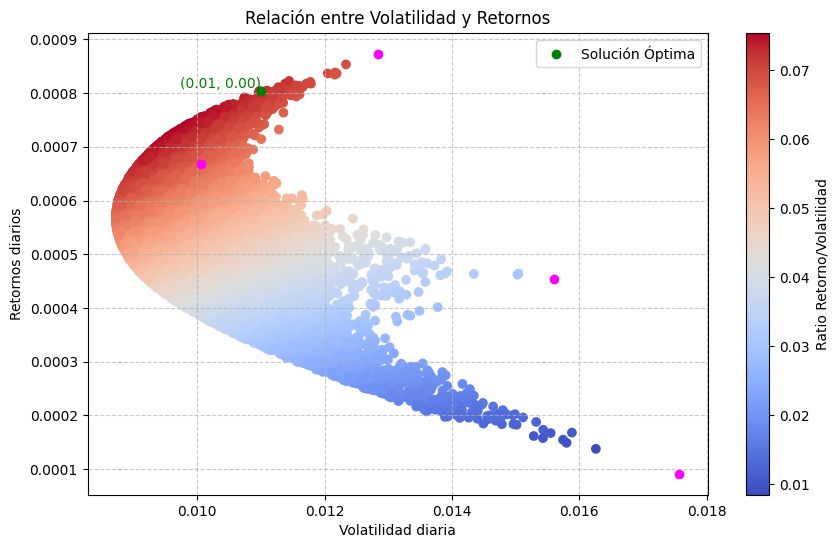

In [ ]:
# Ajustar el tamaño de la figura (ancho x alto en pulgadas)
plt.figure(figsize=(10, 6))

# Gráfico original
plt.scatter(vol_carteras_sim, ret_carteras_sim_mean, c=ret_carteras_sim_mean / vol_carteras_sim, marker='o', cmap='coolwarm')
for a in returns_fondos.columns:
    plt.plot(volatilidades[a], retornos_medios[a], 'o', color="magenta")

# Añadir el punto (vol, ret) en color verde y con etiqueta
plt.plot(vol, ret, 'o', color='green', label='Solución Óptima')
plt.text(vol, ret, f'({vol}, {ret})', fontsize=10, verticalalignment='bottom', horizontalalignment='right', color='green')

# Añadir etiquetas a los ejes
plt.xlabel('Volatilidad diaria')
plt.ylabel('Retornos diarios')

# Título opcional para el gráfico
plt.title('Relación entre Volatilidad y Retornos')

# Barra de color para interpretar los colores
plt.colorbar(label='Ratio Retorno/Volatilidad')

# Leyenda para los puntos
plt.legend()

# Rejilla para facilitar la lectura
plt.grid(True, linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.show()


# Nueva sección